In [1]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 10)})
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")
from pmdarima import auto_arima 
import pandas as pd 
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model  import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('../datatest/monthly-car-sales.csv')

In [3]:
df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


<AxesSubplot:>

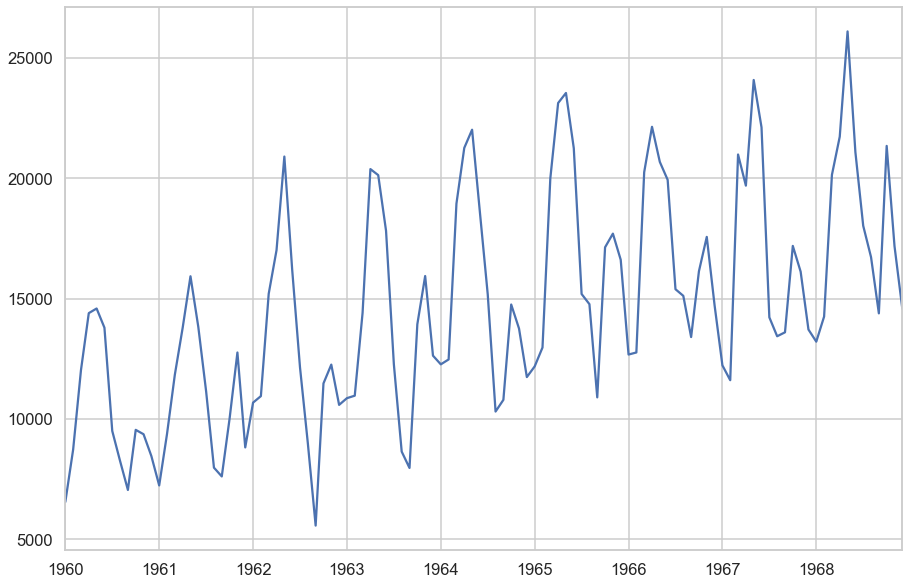

In [4]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)
df['Sales'].plot()

Задание №1 
-------
Разложить на компоненты, используя функцию <code>seasonal_decompose</code>

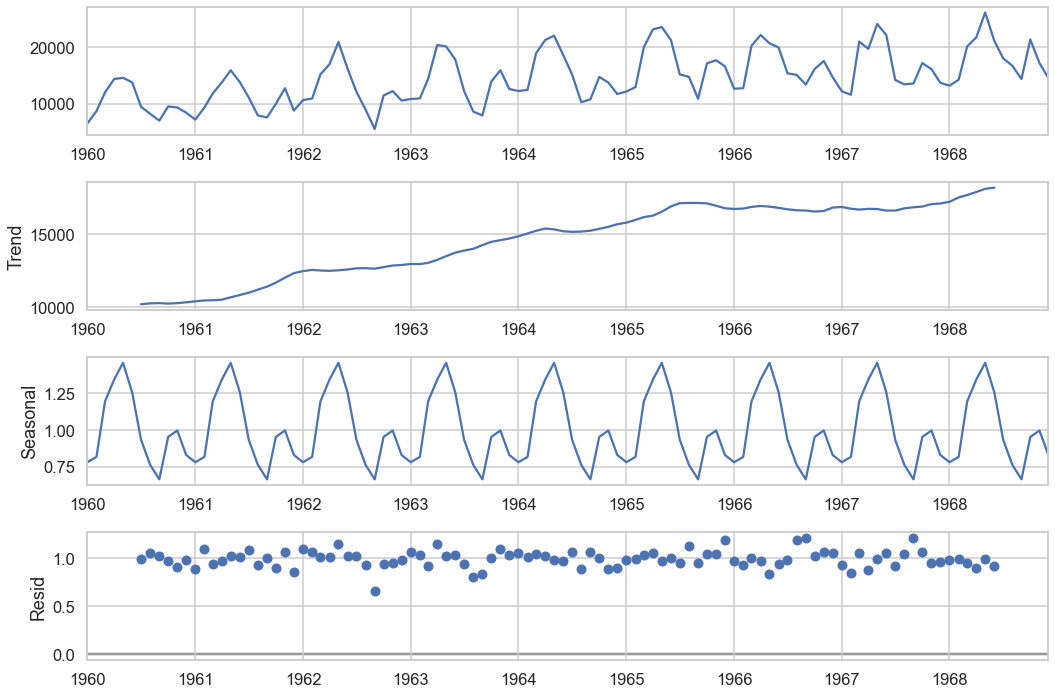

In [5]:
#your code 
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
result = seasonal_decompose(df, model='multiplicative', period=12)
result.plot()
pyplot.show()


Проверим, является ли временной ряд стационарным. 

In [6]:
result = adfuller(df['Sales'])
print('p-value: %f' % result[1])

p-value: 0.663269


Ряд не стационарный, попробуем сделать одну дифференциацию.

In [7]:
df['diff'] = df['Sales'].diff()
df.dropna(inplace=True)

result = adfuller(df['diff'])
print('p-value: %f' % result[1])

p-value: 0.000000


<AxesSubplot:>

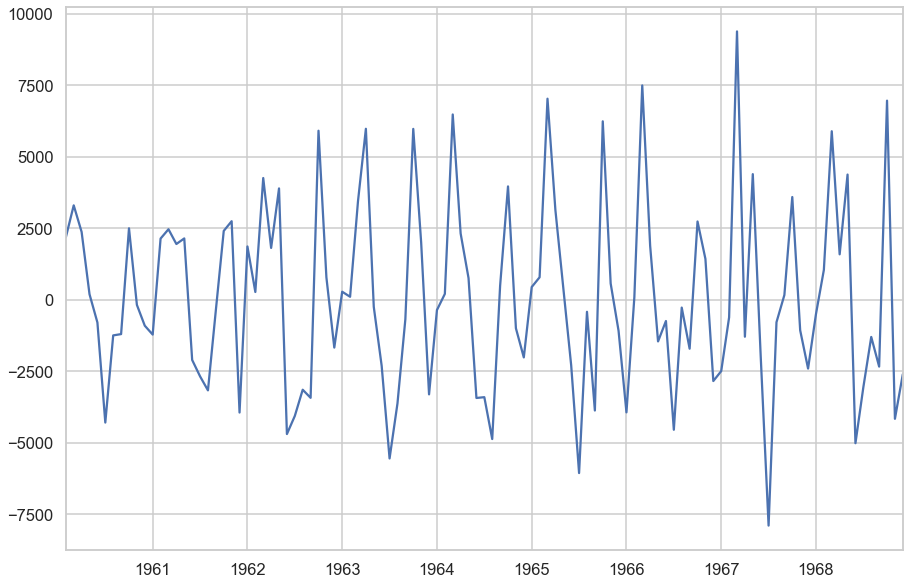

In [8]:
df['diff'].plot()

Задание №2
------
Сделать графики авто корреляции и часточной автокорреляции с помощью функций <code> plot_acf </code> и <code> plot_pacf </code>.

Если при использовании функции <code> plot_pacf </code> появляется ошибка <code>RuntimeWarning: invalid value encountered in sqrt</code> , можно изменить дефолтное значение метода, используемого для рассчета частичной автокорреляции. Почитать про методы можно почитать здесь:
<a>https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html</a>

Попробуйте использовать <code> method = 'ldadjusted' </code>

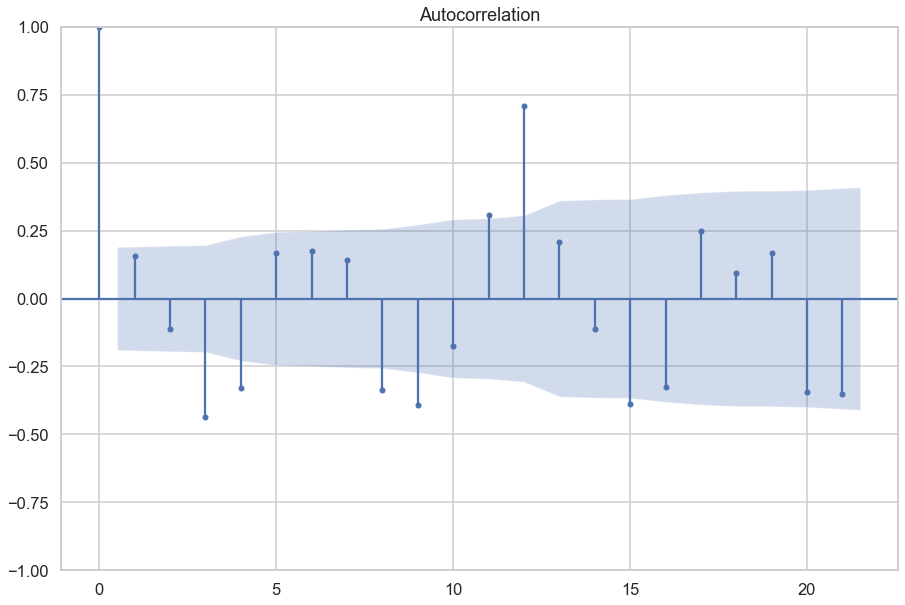

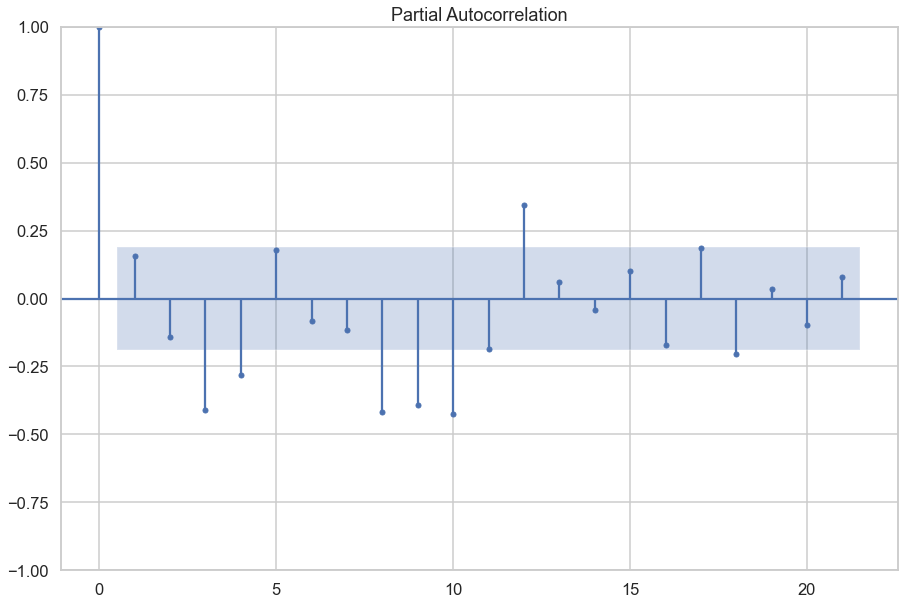

In [12]:
#your code 
plot_acf(df['diff'].dropna())
plt.show()

plot_pacf(df['diff'].dropna(), method = 'ywm')
plt.show()


In [13]:
# split data into train and test

# what is the size of 80% ? 
size = int(len(df)*0.8)

# use 80% for train and 20% for test

train, test = df[0:size], df[size:]
print(f'Length of train is {len(train)} and lenght of test is {len(test)}')

Length of train is 85 and lenght of test is 22


In [19]:
model = ARIMA(train['Sales'], order=(2,1,2))
model_fit = model.fit(cov_type = 'approx')
preds = model_fit.forecast(len(test))

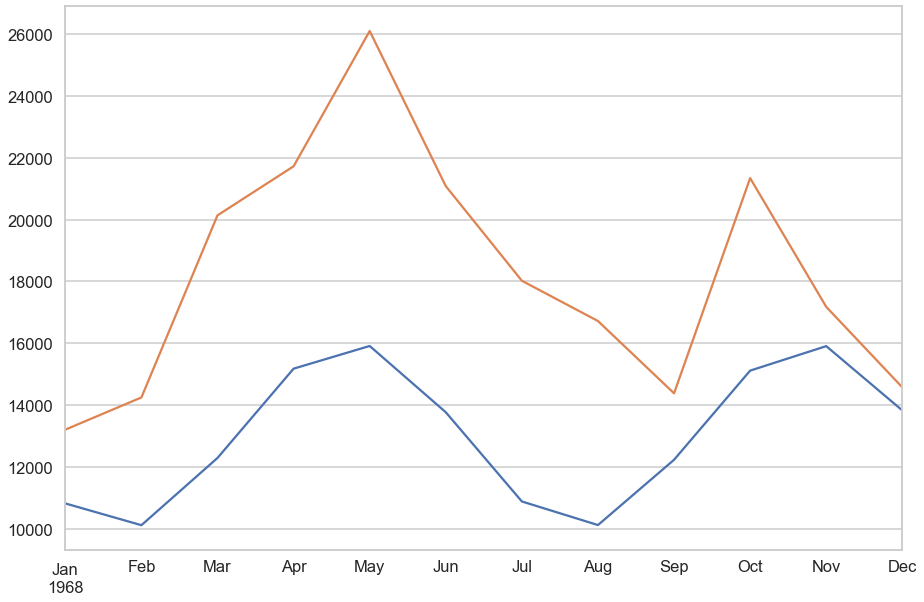

In [20]:
preds.plot()
test['Sales'].plot()
plt.show()

Задание №3
===
Используя <code>auto_arima</code> найти оптимальный набор параметров, натренировать на нем модель (на тренировочных данных) и сделать прогноз для теста. Сделать графики и посчитать качество предсказаний, используя метрики <code> r2_score </code> и <code> mean_absolute_error </code>.

In [28]:
# your code
SARIMA_model = auto_arima(train["Sales"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

SARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   95
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -731.246
Date:                            Thu, 30 Jun 2022   AIC                           1472.491
Time:                                    23:33:54   BIC                           1484.585
Sample:                                         0   HQIC                          1477.350
                                             - 95                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    473.5443    265.727      1.782      0.075     -47.270     994.359
ar.L1          0.2602      0.125      2.088      0.037       0.016       0.504
ar.L2          0.2514      0.124      2.030      0.042       0.009       0.494
ar.S.L12      -0.2049      0.094     -2.169      0.030      -0.390      -0.020
sigma2      2.739e+06   5.16e+05      5.305      0.000    1.73e+06    3.75e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.78
Prob(Q):                              0.88   Prob(JB):                         0.68
Heteroskedasticity (H):               1.16   Skew:                             0.09
Prob(H) (two-sided):                  0.70   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:

order = (2,0,0)
seasonal_order = (1,1,0,12)

SARIMA_model = ARIMA(train, order=order, seasonal_order=seasonal_order)

SARIMA_model_fit = SARIMA_model.fit()

predictions = SARIMA_model_fit.forecast(len(test))

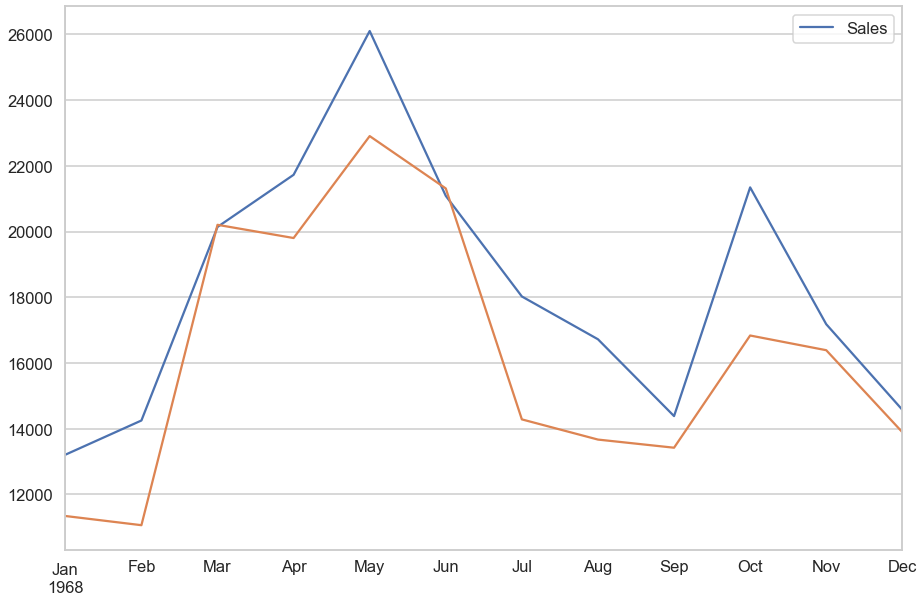

In [30]:
test.plot()
predictions.plot()
plt.show()


In [39]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae

r2_score(test, predictions), mae(test, predictions)

(0.5648201318940109, 2015.7013307120408)